In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
filename = "NanoAOD/NMSSM_XYH_YToHH_6b_MX_700_MY_400_accstudies_500k_Jul2021-v2.root"
tree = Tree(filename)

In [3]:
higgs_labels = ["HX","HY1","HY2"]
zipped_higgs = lambda var : ak.concatenate([tree[f"gen_{higgs}_{var}"][:,np.newaxis] for higgs in higgs_labels],axis=-1)

In [4]:
gen_h_pt = zipped_higgs("pt")
gen_h_eta = zipped_higgs("eta")
gen_h_phi = zipped_higgs("phi")
gen_h_m = zipped_higgs("m")
gen_h_id = ak.local_index(gen_h_m,axis=-1)

In [5]:
signal_labels = ["HX_b1","HX_b2","HY1_b1","HY1_b2","HY2_b1","HY2_b2"]
zipped_bs = lambda var : ak.concatenate([tree[f"gen_{signal}_{var}"][:,np.newaxis] for signal in signal_labels],axis=-1)

In [6]:
gen_b_id = ak.local_index(tree["signal_genjet_idxs"],axis=-1)
gen_b_pt = zipped_bs("pt")
gen_b_eta = zipped_bs("eta")
gen_b_phi = zipped_bs("phi")
gen_b_m = zipped_bs("m")

In [7]:
all_bjets = gen_b_id > -1
b_list_mask = [ gen_b_id == id for id in range(6) ]

In [8]:
gen_bjet_pt  = tree["genjet_pt"][tree["signal_genjet_idxs"]]
gen_bjet_eta = tree["genjet_eta"][tree["signal_genjet_idxs"]]
gen_bjet_phi = tree["genjet_phi"][tree["signal_genjet_idxs"]]
gen_bjet_m   = tree["genjet_m"][tree["signal_genjet_idxs"]]
gen_bjet_id = tree["genjet_signal_id"][tree["signal_genjet_idxs"]]
gen_bjet_recoidx = tree["genjet_recoidx"][tree["signal_genjet_idxs"]]

In [9]:
reco_bjet_pt  = tree["jet_pt"][tree[ "signal_jet_idxs"]]
reco_bjet_eta = tree["jet_eta"][tree["signal_jet_idxs"]]
reco_bjet_phi = tree["jet_phi"][tree["signal_jet_idxs"]]
reco_bjet_m   = tree["jet_m"][tree[  "signal_jet_idxs"]]
reco_bjet_id = tree["jet_signal_id"][tree["signal_jet_idxs"]]
reco_bjet_genidx = tree["jet_genidx"][tree["signal_jet_idxs"]]

In [10]:
b_to_gj_dr, b_min_gj_dr, b_imin_gj_dr, _, _ = get_ext_dr(gen_b_eta,gen_b_phi,tree["genjet_eta"],tree["genjet_phi"])
h_to_h_dr,  h_min_h_dr,  h_imin_h_dr, _, _ = get_ext_dr(gen_h_eta,gen_h_phi,gen_h_eta,gen_h_phi)  

# Missing Gen BJets

In [11]:
def bjet_mask_composition(bjet_mask,tag,total_bjet_mask=all_bjets):
        
    nbjet_mask = ak.sum(bjet_mask,axis=-1)
    bjet_ids = gen_b_id[bjet_mask]
    g_min_dr_idx = b_imin_gj_dr[bjet_mask]
    g_min_dr_b_id = tree["genjet_signal_id"][g_min_dr_idx]
    
    total_nbjet_mask = ak.sum(total_bjet_mask,axis=-1)
    
    print(f"--Event Fraction w/ {tag}: {ak.sum(nbjet_mask>0)/ak.sum(total_nbjet_mask>0):0.2f}")
    print(f"----Fraction of {tag}:     {ak.sum(nbjet_mask/6)/ak.sum(total_nbjet_mask/6):0.2f}")
    
    if ak.sum(nbjet_mask>0) == 0: return False
    
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(16,5))
    hist_multi([nbjet_mask],bins=range(7),xlabel=f"N {tag}",density=1,figax=(fig,axs[0]))
    hist_multi([ak.flatten(bjet_ids)],bins=range(7),xlabel=f"{tag} IDs",ylabel=f"Fraction of {tag}",density=1,figax=(fig,axs[1]))
    hist_multi([g_min_dr_b_id],bins=range(-1,7),xlabel=f"{tag} Nearest Gen BJet IDs",ylabel=f"Fraction of {tag}",density=1,figax=(fig,axs[2]))
                            
    fig.tight_layout()
    plt.show()
    return True

In [12]:
def bjet_mask_distributions(bjet_mask,tag):
        
    b_pt =  gen_b_pt[bjet_mask]
    b_eta = gen_b_eta[bjet_mask]
    b_phi = gen_b_phi[bjet_mask]
    min_gj_dr = b_min_gj_dr[bjet_mask]
    
    g_min_dr_idx = b_imin_gj_dr[bjet_mask]
    
    genjet_mask = get_jet_index_mask(tree["genjet_signal_id"],g_min_dr_idx)
    g_min_dr_b_id = tree["genjet_signal_id"][genjet_mask]
    near_gj_pt = tree["genjet_pt"][genjet_mask]
    near_gj_eta = tree["genjet_eta"][genjet_mask]
    near_b_pt = gen_b_pt[g_min_dr_b_id]
    near_b_eta = gen_b_eta[g_min_dr_b_id]
    
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(16,5))
    labels = [tag,"Closest Gen Jet","Closest Gen B"]
    histtypes = ["bar","step","step"]
    hist_multi([b_pt,near_gj_pt,near_b_pt],bins=np.linspace(0,500,50),xlabel=f"Pt",labels=labels,histtypes=histtypes,figax=(fig,axs[0]))
    hist_multi([b_eta,near_gj_eta,near_b_eta],bins=np.linspace(-5,5,50),xlabel=f"Eta",labels=labels,histtypes=histtypes,figax=(fig,axs[1]))
    hist_multi([min_gj_dr],bins=np.linspace(0,4,50),xlabel=f"{tag} Closest Gen Jet dR",figax=(fig,axs[2]))
                            
    fig.tight_layout()
    plt.show()

In [13]:
def h_mask_distributions(bjet_mask,tag):
    nrows,ncols=1,3
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(16,5))
    nbjet_mask = ak.sum(bjet_mask,axis=-1)
    mask = nbjet_mask > 0
    
    higgs_pt = [ gen_h_pt[:,i][mask] for i in range(3) ]
    higgs_min_h_dr = [ h_min_h_dr[:,i][mask] for i in range(3) ]
    higgs_imin_h_dr = [ h_imin_h_dr[:,i][mask] for i in range(3) ]
        
    hist_multi(higgs_pt ,bins=np.linspace(0,1000,50),xlabel=f"Higgs Pt",labels=higgs_labels,figax=(fig,axs[0]))
    hist_multi(higgs_min_h_dr,bins=np.linspace(0,4,50),xlabel=f"Higgs Closest Gen H dR",labels=higgs_labels,figax=(fig,axs[1]))
    hist_multi(higgs_imin_h_dr,bins=range(4),xlabel=f"Higgs Closest Gen H IDs",labels=higgs_labels,density=1,figax=(fig,axs[2]))
              
    fig.tight_layout()
    plt.show()

In [14]:
def unmatched_bjet_study(bjet_mask,tag,total_bjet_mask=all_bjets):
    
    has_events = bjet_mask_composition(bjet_mask,tag,total_bjet_mask)
    
    if not has_events: return
    bjet_mask_distributions(bjet_mask,tag)
#     h_mask_distributions(bjet_mask,tag)

--Event Fraction w/ Umatched B: 0.53
----Fraction of Umatched B:     0.11


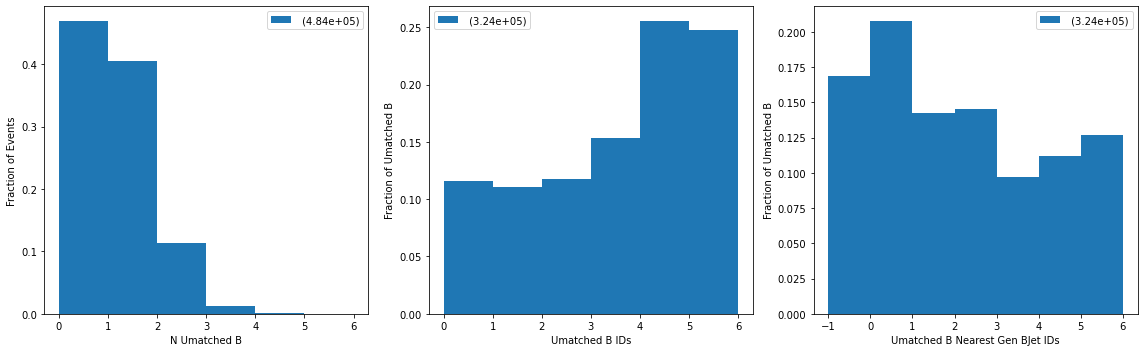

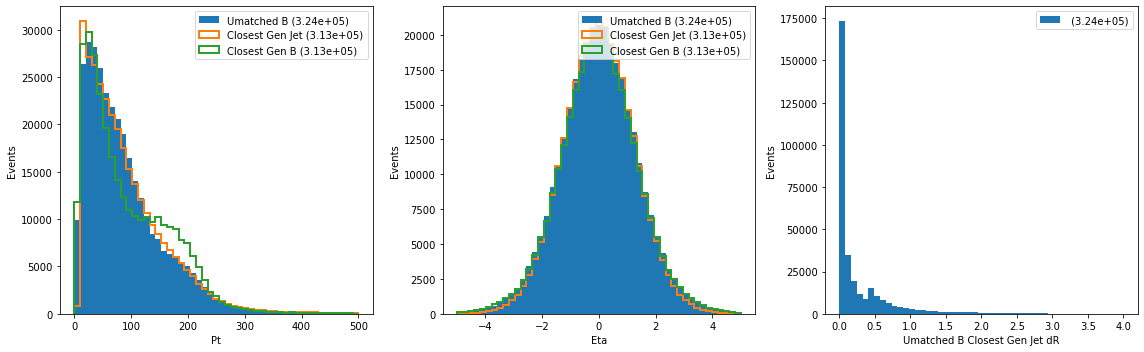

In [15]:
missing_gbj_mask = tree["signal_genjet_idxs"] == -1
unmatched_bjet_study(missing_gbj_mask,"Umatched B")

--Event Fraction w/ Unmatched Iso B: 0.27
----Fraction of Unmatched Iso B:     0.24


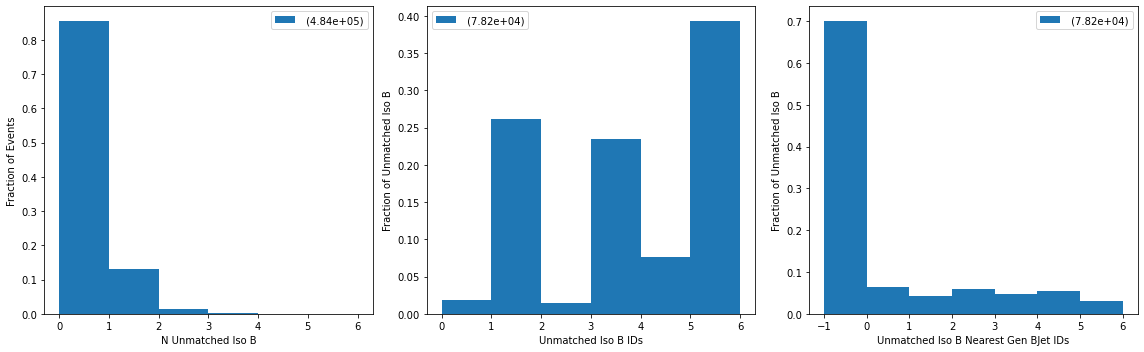

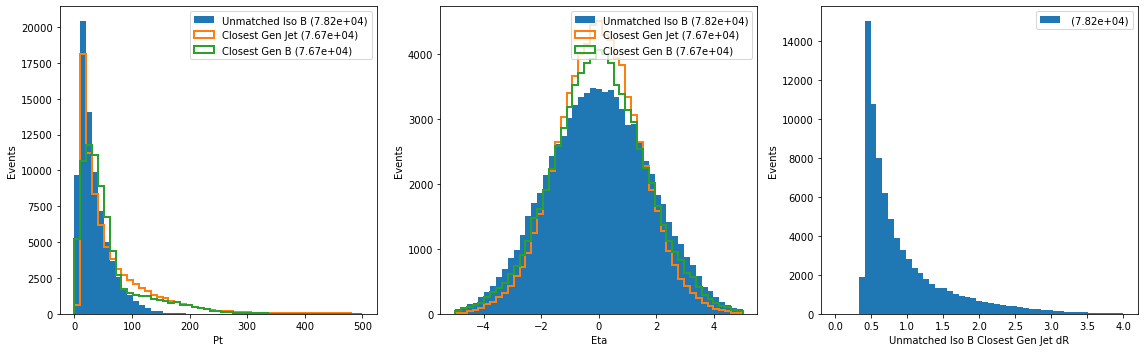

In [16]:
iso_b_mask = b_min_gj_dr >= 0.4
g_unmatched_iso_b_mask = iso_b_mask & missing_gbj_mask

unmatched_bjet_study(g_unmatched_iso_b_mask,"Unmatched Iso B",missing_gbj_mask)

--Event Fraction w/ Unmatched Iso HX_b1: 0.02
----Fraction of Unmatched Iso HX_b1:     0.02


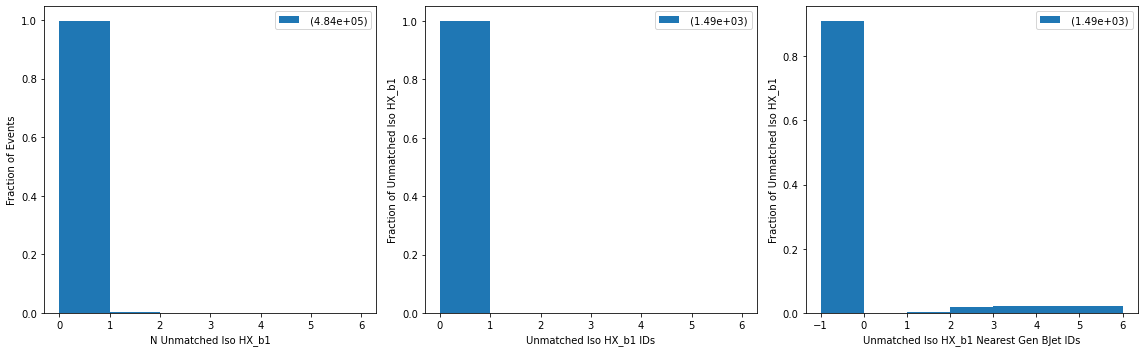

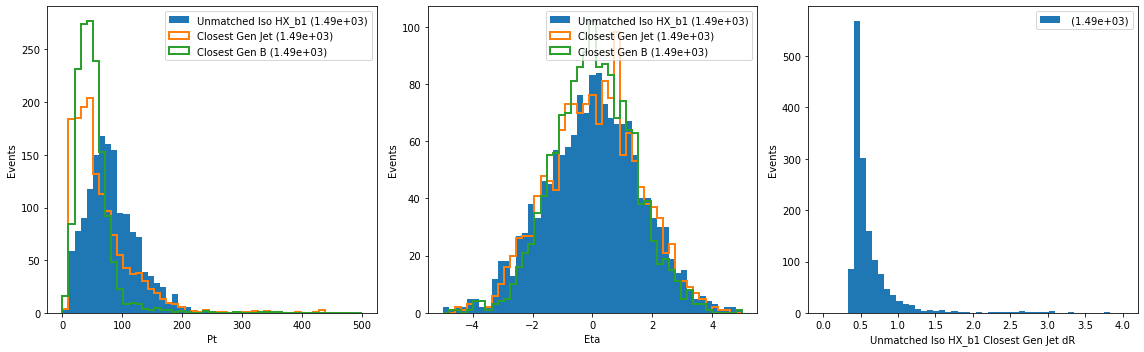

--Event Fraction w/ Unmatched Iso HX_b2: 0.29
----Fraction of Unmatched Iso HX_b2:     0.26


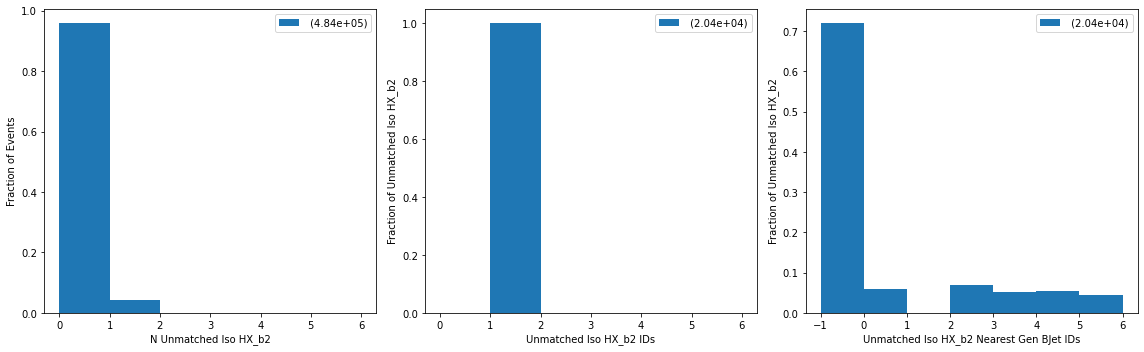

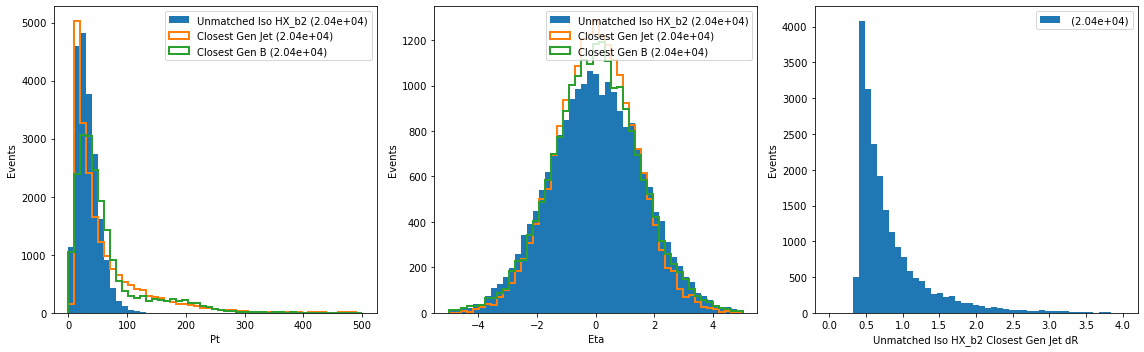

--Event Fraction w/ Unmatched Iso HY1_b1: 0.02
----Fraction of Unmatched Iso HY1_b1:     0.01


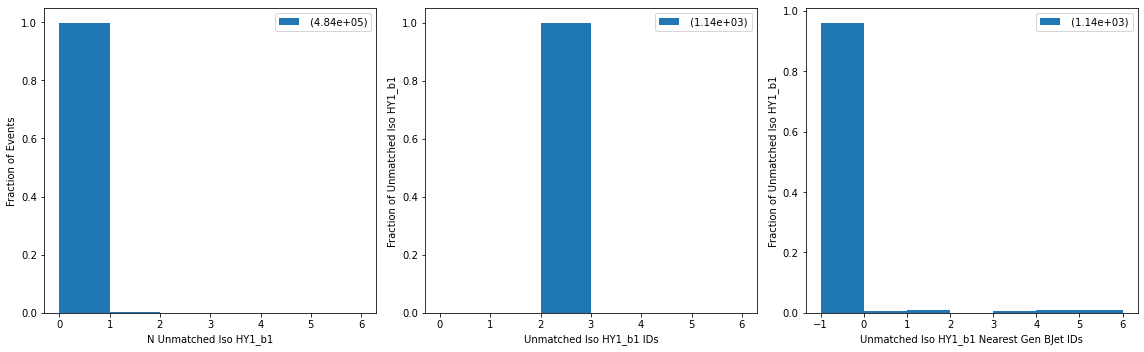

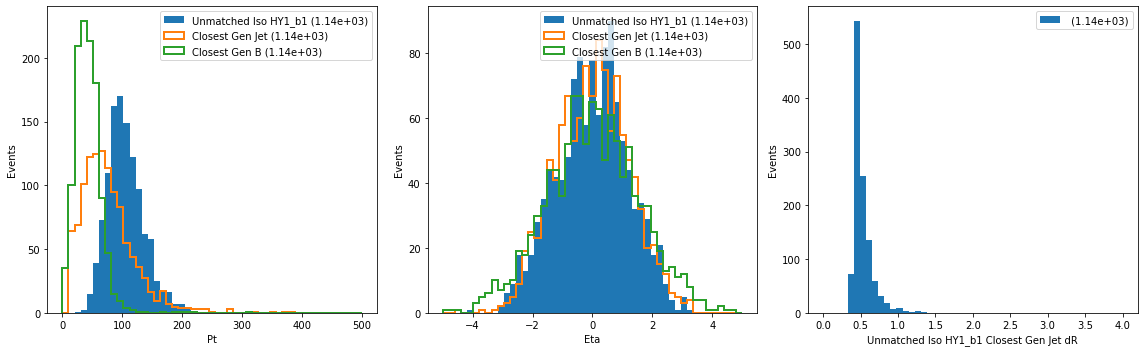

--Event Fraction w/ Unmatched Iso HY1_b2: 0.26
----Fraction of Unmatched Iso HY1_b2:     0.24


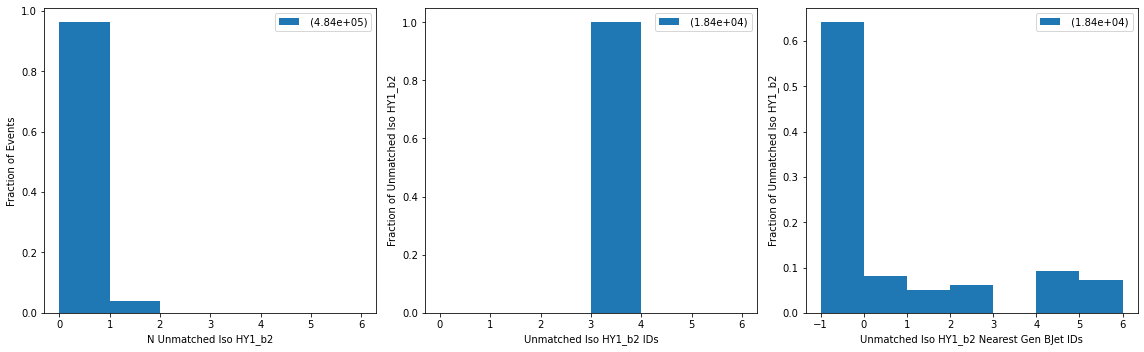

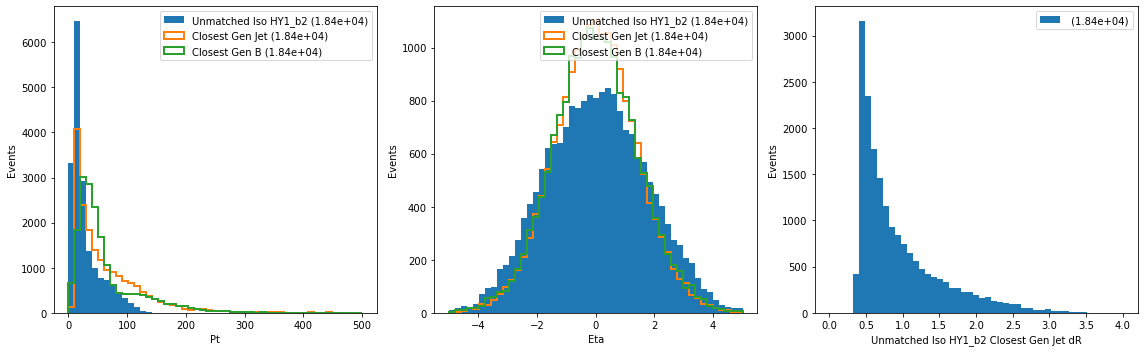

--Event Fraction w/ Unmatched Iso HY2_b1: 0.09
----Fraction of Unmatched Iso HY2_b1:     0.08


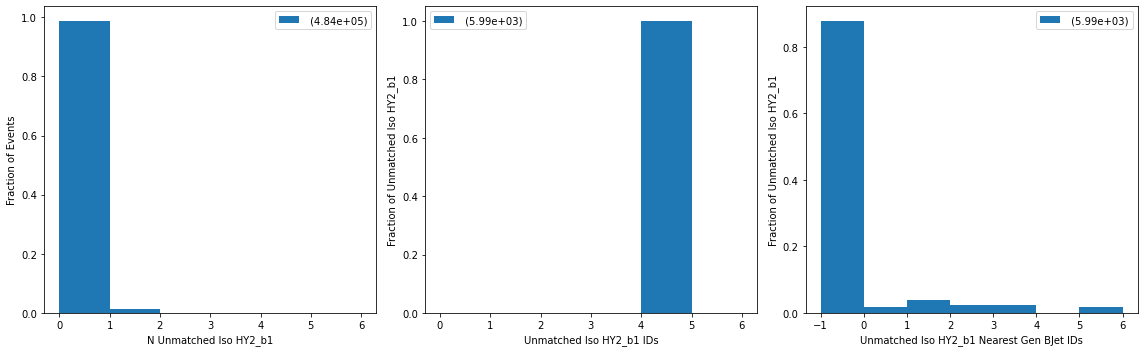

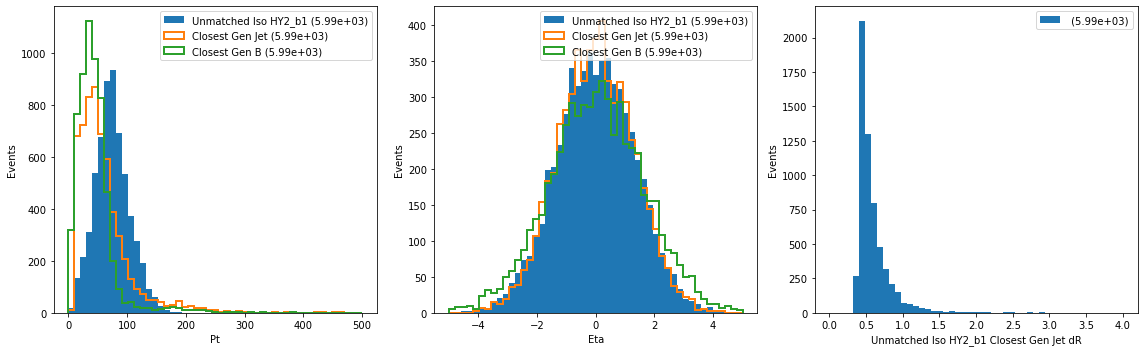

--Event Fraction w/ Unmatched Iso HY2_b2: 0.44
----Fraction of Unmatched Iso HY2_b2:     0.39


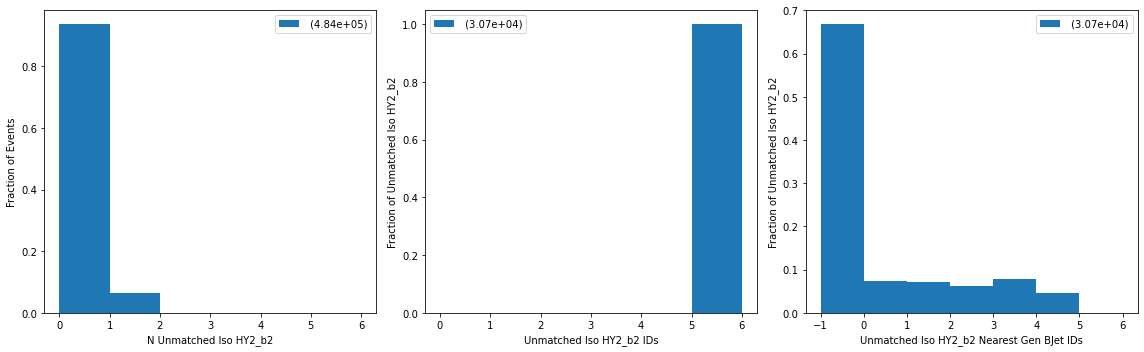

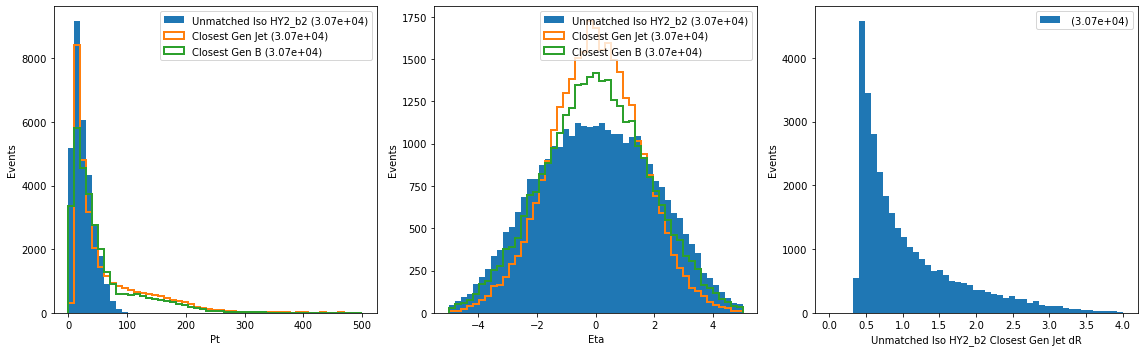

In [17]:
for i,b_imask in enumerate(b_list_mask): 
    b_imask = b_imask & g_unmatched_iso_b_mask
    unmatched_bjet_study(b_imask,f"Unmatched Iso {signal_labels[i]}",g_unmatched_iso_b_mask)

--Event Fraction w/ Unmatched Non-Iso B: 0.85
----Fraction of Unmatched Non-Iso B:     0.76


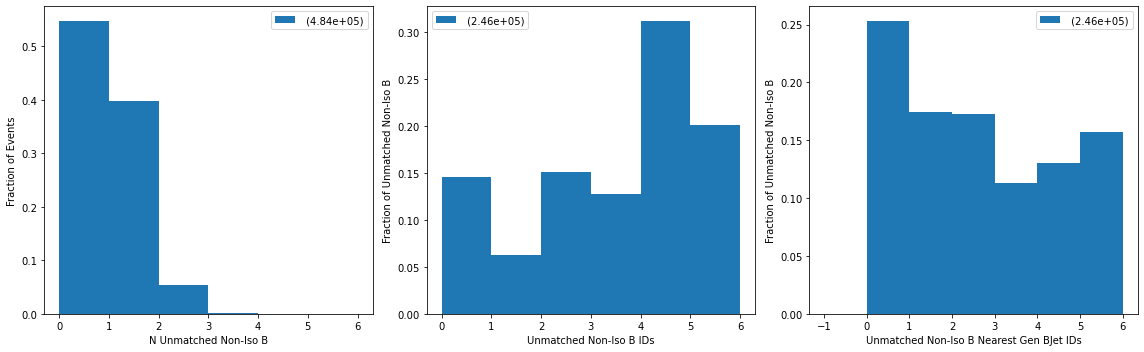

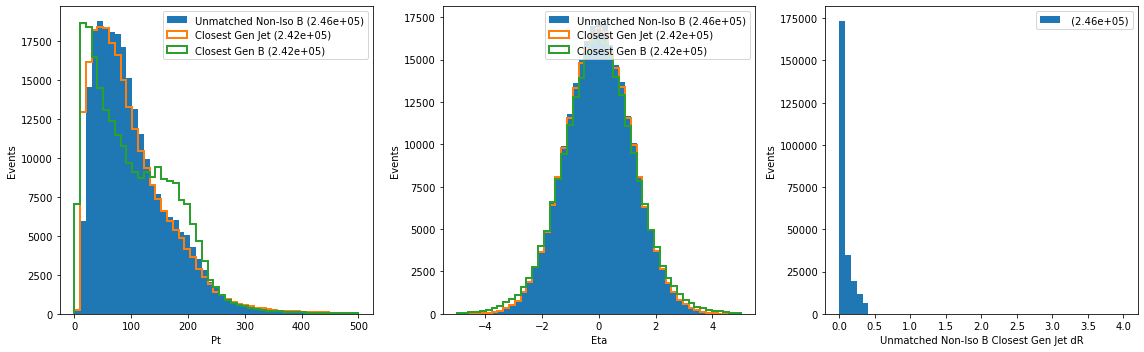

In [18]:
noniso_b_mask = b_min_gj_dr < 0.4
g_unmatched_noniso_b_mask = noniso_b_mask & missing_gbj_mask
unmatched_bjet_study(g_unmatched_noniso_b_mask,"Unmatched Non-Iso B",missing_gbj_mask)

--Event Fraction w/ Unmatched Non-Iso HX_b1: 0.16
----Fraction of Unmatched Non-Iso HX_b1:     0.15


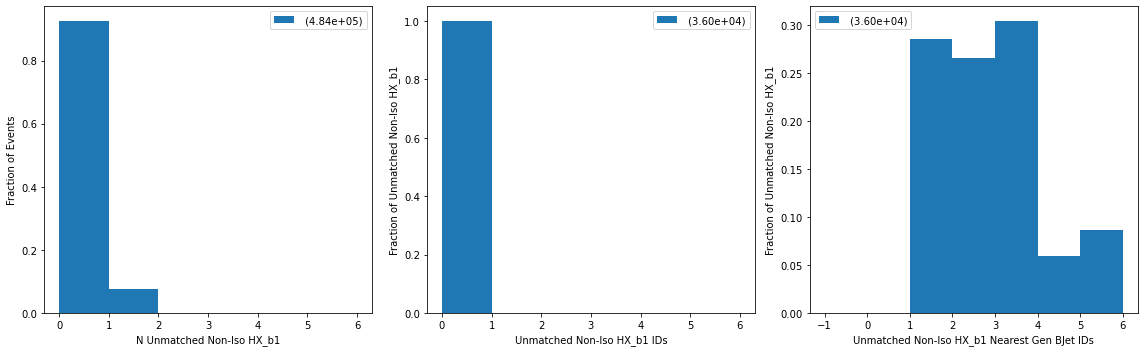

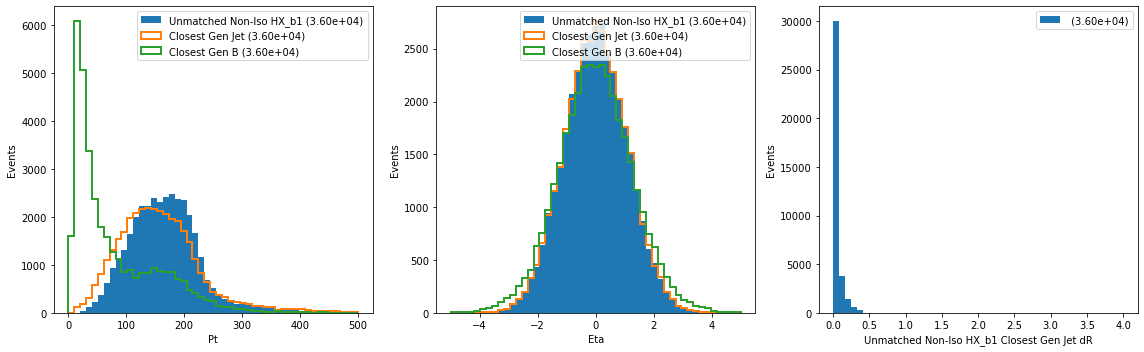

--Event Fraction w/ Unmatched Non-Iso HX_b2: 0.07
----Fraction of Unmatched Non-Iso HX_b2:     0.06


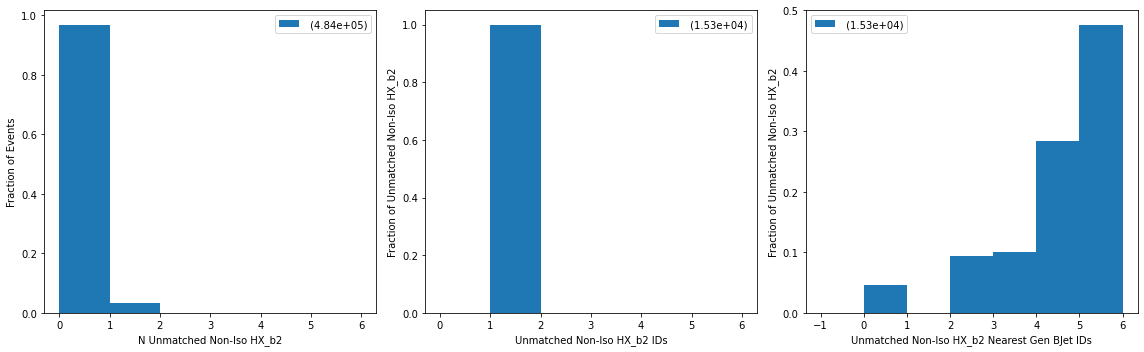

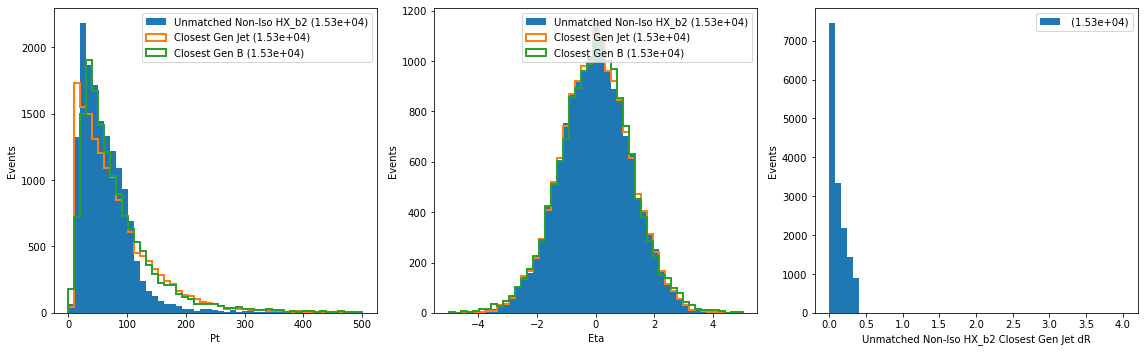

--Event Fraction w/ Unmatched Non-Iso HY1_b1: 0.17
----Fraction of Unmatched Non-Iso HY1_b1:     0.15


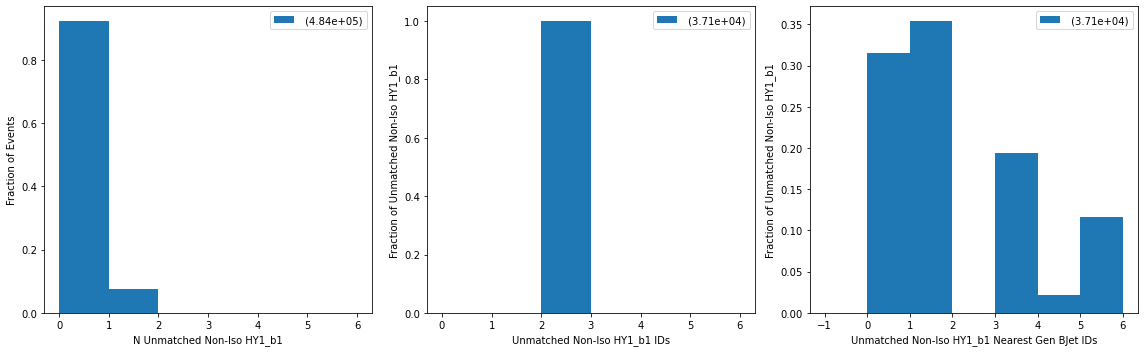

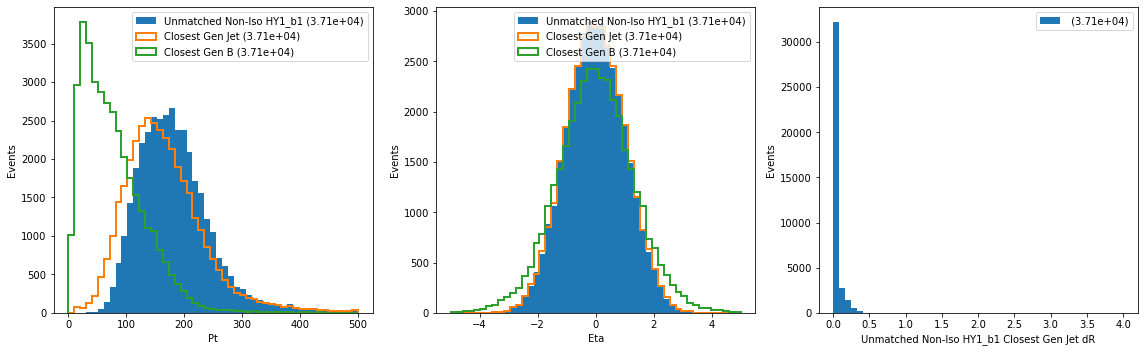

--Event Fraction w/ Unmatched Non-Iso HY1_b2: 0.14
----Fraction of Unmatched Non-Iso HY1_b2:     0.13


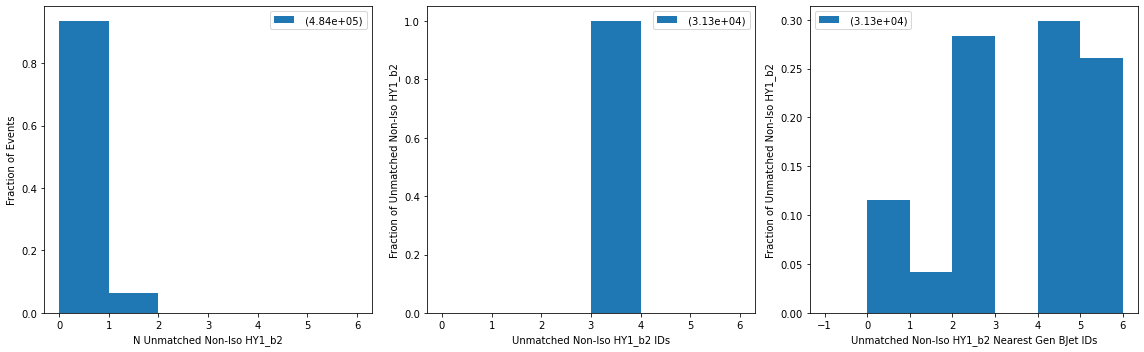

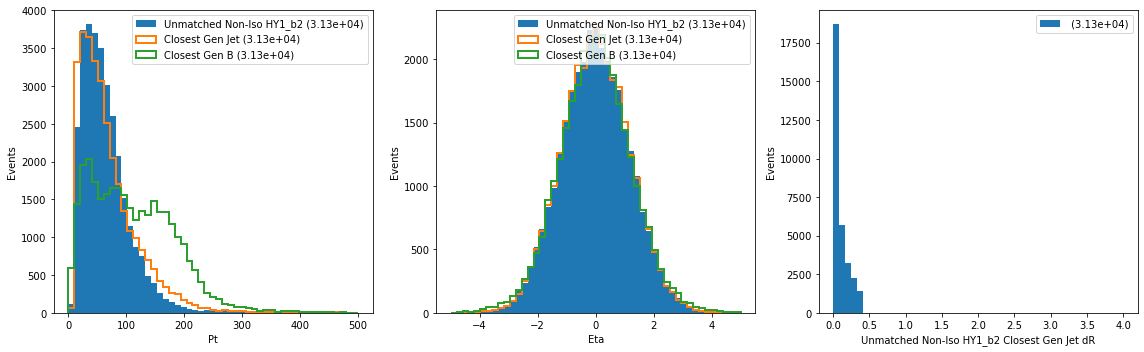

--Event Fraction w/ Unmatched Non-Iso HY2_b1: 0.35
----Fraction of Unmatched Non-Iso HY2_b1:     0.31


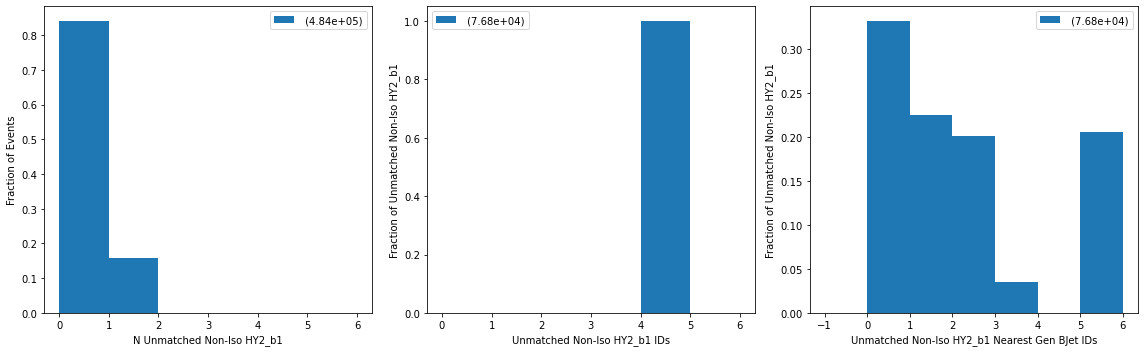

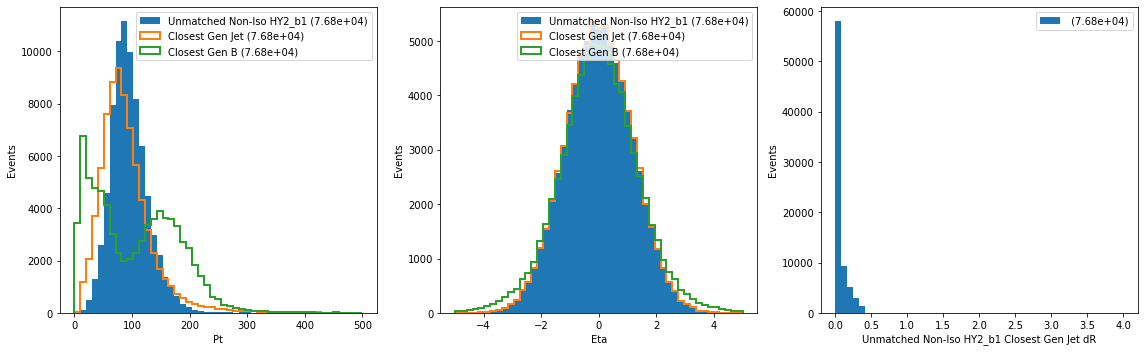

--Event Fraction w/ Unmatched Non-Iso HY2_b2: 0.23
----Fraction of Unmatched Non-Iso HY2_b2:     0.20


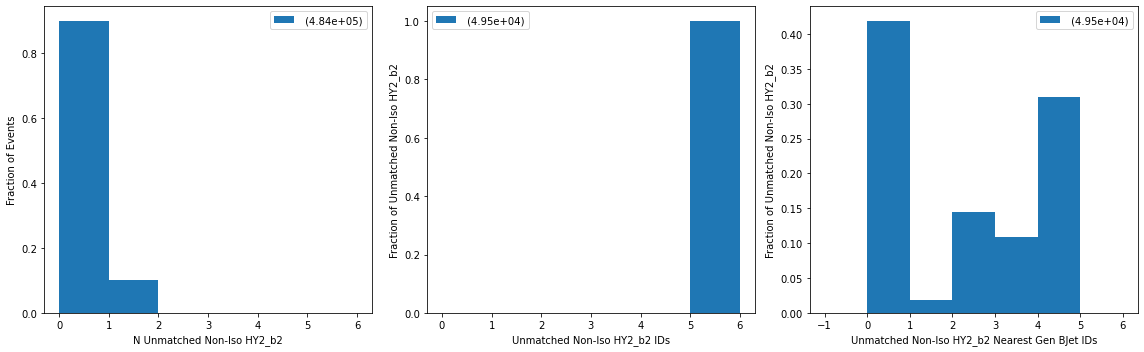

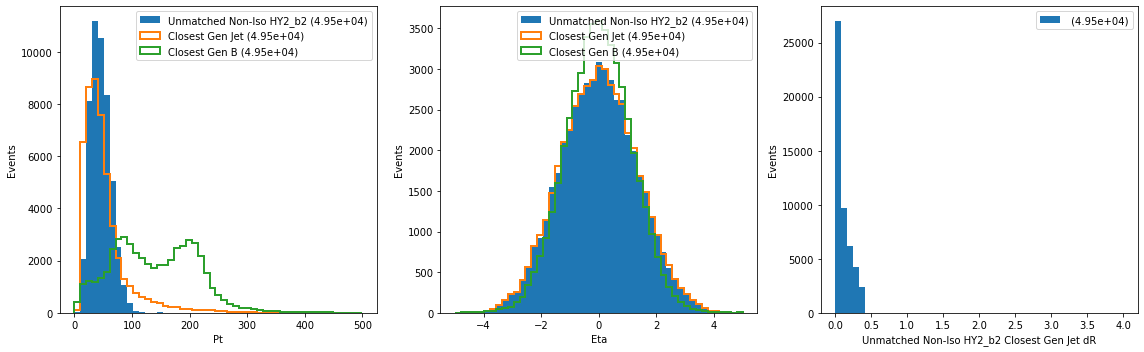

In [19]:
for i,b_imask in enumerate(b_list_mask): 
    b_imask = b_imask & g_unmatched_noniso_b_mask
    unmatched_bjet_study(b_imask,f"Unmatched Non-Iso {signal_labels[i]}",g_unmatched_noniso_b_mask)